In [6]:
from environment import Environment, FixedBudgetEnvironment
import matplotlib.pyplot as plt
import math
import numpy as np
from game import SumUnanimityGames, GlobalFeatureImportance, LocalFeatureImportance, UnsupervisedFeatureImportance
from plot import plot_order
import util

In [7]:
from algorithms.CMCS import CMCS, CMCS_Dependent, CMCS_Independent, CMCS_Length
from algorithms.GapE import GapE
from algorithms.SAR import SAR
from algorithms.ApproShapley import ApproShapley
from algorithms.BUS import BUS
from algorithms.HybridApproBUS import SmartHybridApproBUS
from algorithms.SVARM import SVARM, StratSVARM
from algorithms.ShapleySort import ShapleySort
from algorithms.KernelSHAP import KernelSHAP
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
n=14
k=8
budget=1000
rounds=1000
step_interval=50
metric = "ratio"
env = Environment(n=n, budget=budget, metric=metric)
results = []

In [9]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [10]:
filepath_global = "datasets/Global feature importance/Wine classification random forest.csv"
filepath_unsupervised = "datasets/Unsupervised Feature Importance/vf_Fifa.csv"
directory_local = "datasets/adult classification"
# game = GlobalFeatureImportance(filepath=filepath_global, num_players=n, use_cached=True)
game = LocalFeatureImportance(directory=directory_local, num_players=n)
# game = UnsupervisedFeatureImportance(filepath=filepath_unsupervised, num_players=n)
# game = SumUnanimityGames()

In [14]:
values, games = game.reindex_all()
# shapley_values, _ = game.get_all_phi(values)
values.shape

(60, 16384)

In [18]:
shapley_values, _ = game.get_all_phi(values)
shapley_values.shape

(60, 14)

In [27]:
var = game.calc_variance(values, shapley_values)
cov = game.calc_covariance(values, shapley_values)
var.shape, cov.shape

((60, 14), (60, 14, 14))

In [ ]:
var_diff_independent = np.zeros_like(cov)
var_diff_independent = var[:, :, np.newaxis] + var[:, np.newaxis, :]
var_diff_dependent = var_diff_independent - 2 * cov
var_diff_dependent

array([[[0.00, 0.03, 0.00, ..., 0.00, 0.00, 0.01],
        [0.03, 0.00, 0.03, ..., 0.03, 0.03, 0.04],
        [0.00, 0.03, 0.00, ..., 0.00, 0.00, 0.00],
        ...,
        [0.00, 0.03, 0.00, ..., 0.00, 0.00, 0.01],
        [0.00, 0.03, 0.00, ..., 0.00, 0.00, 0.00],
        [0.01, 0.04, 0.00, ..., 0.01, 0.00, 0.00]],

       [[0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, ..., -0.00, 0.00, -0.00],
        ...,
        [0.00, 0.00, -0.00, ..., 0.00, 0.00, -0.00],
        [0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
        [0.00, 0.00, -0.00, ..., -0.00, 0.00, 0.00]],

       [[0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.01],
        [0.00, 0.00, 0.00, ..., -0.00, 0.00, 0.00],
        ...,
        [0.00, 0.00, -0.00, ..., 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
        [0.00, 0.01, 0.00, ..., 0.00, 0.00, 0.00]],

       ...,

       [[0.00, 0

In [54]:
relative_variance = var_diff_dependent / var_diff_independent
relative_variance_pairs = relative_variance[:, *np.triu_indices(n, k=1)]
relative_variance_pairs.shape
assert relative_variance_pairs.shape[1] == n*(n-1)/2
relative_variance_pairs.shape

C:\Users\Tim\AppData\Local\Temp\ipykernel_19624\3484392039.py:1: RuntimeWarning: invalid value encountered in divide
  relative_variance = var_diff_dependent / var_diff_independent


(60, 91)

In [55]:
np.histogram(relative_variance_pairs, bins=10)

ValueError: autodetected range of [nan, nan] is not finite

<BarContainer object of 20 artists>

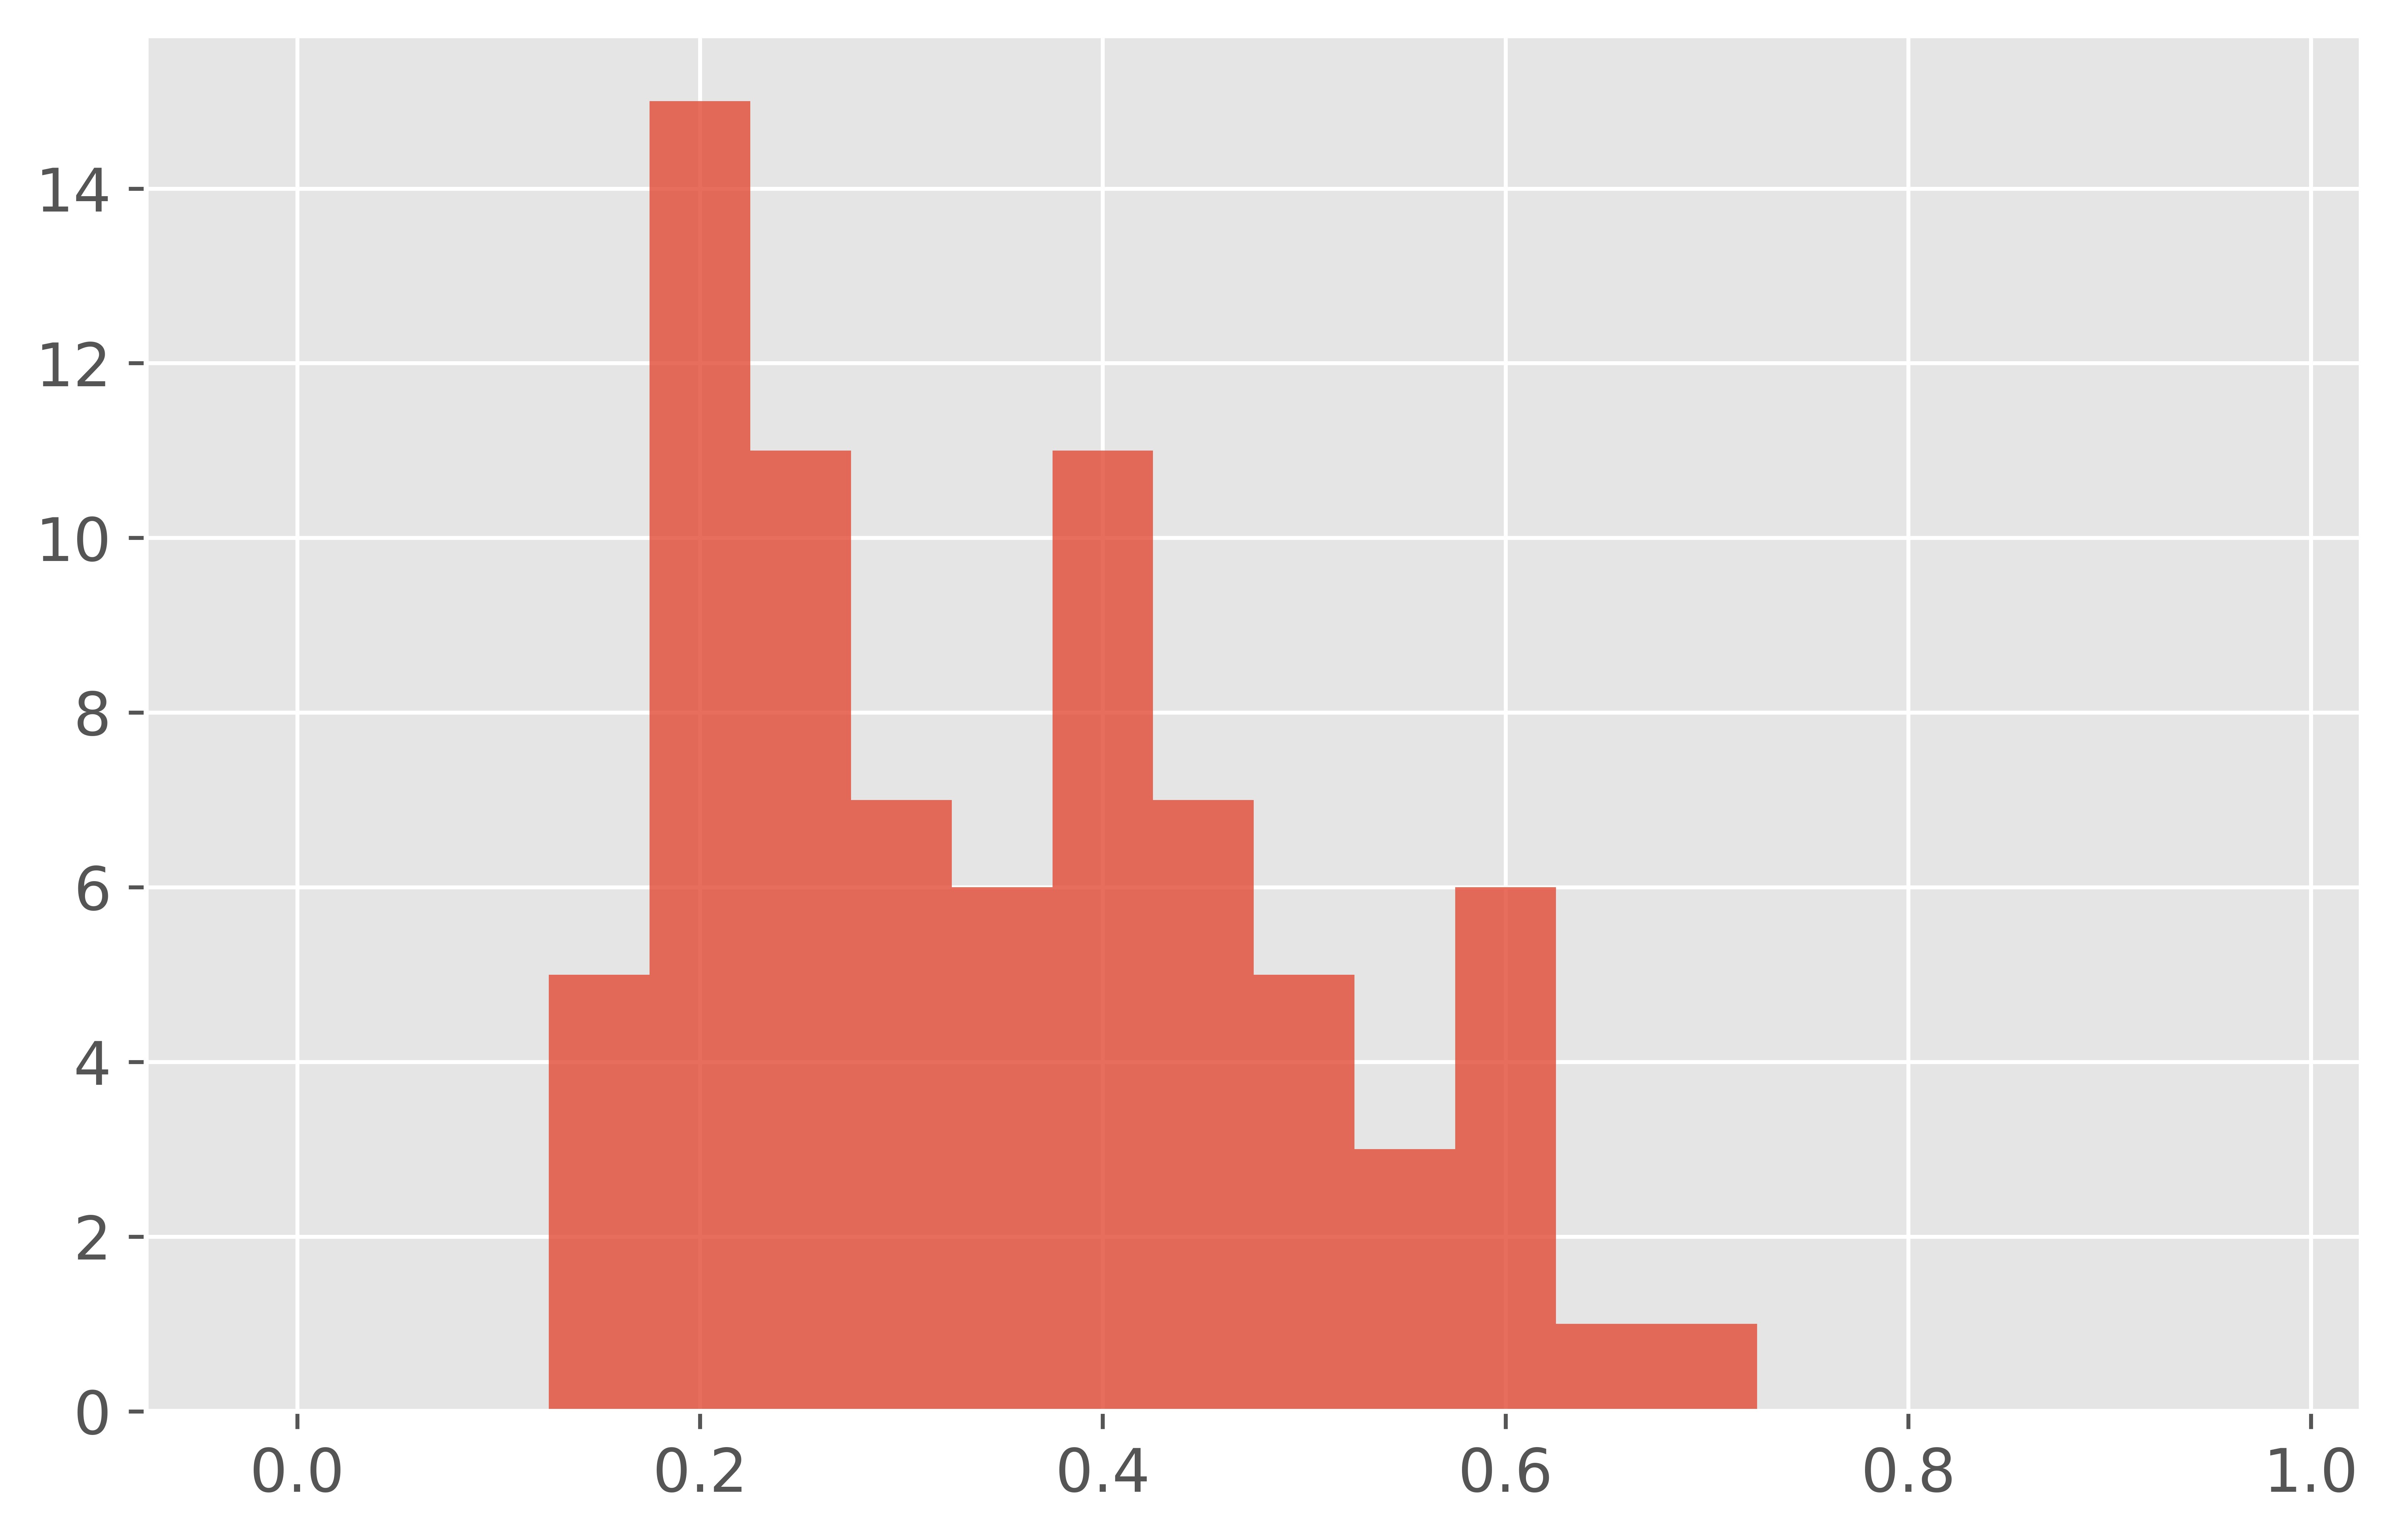

In [ ]:
plt.style.use(plt.style.library['ggplot'])
plt.rcParams.update({'font.size': 12})
plt.rcParams['legend.frameon'] = False
plt.rcParams['lines.markersize'] = 10
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=1000)
counts, edges = np.histogram(relative_variance_pairs, bins=20, range=(0,1))
x = edges[:-1]
widths = edges[1:] - edges[:-1]
ax.bar(x, counts, widths, alpha=0.8)